In [3]:
from PIL import Image
import numpy as np
import glob
import pandas as pd
import copy
from scipy import misc
from os import path
import re
import sys
sys.path.append('../../process')
import psml

In [22]:
'''Description'''

'Description'

In [19]:
%%time
#This is a good way to run out of memory.
trace_dir_path = 'traces/'
trace_paths = !ls {trace_dir_path}
labels = np.array([ i[i.find('for')-1] for i in trace_paths])
trace_paths = [ trace_dir_path + i for i in trace_paths]
# traces = psml.paths_to_tracearr(trace_paths)
# traces.shape, labels.shape

#print(labels)
trace_paths

CPU times: user 1.83 ms, sys: 3.41 ms, total: 5.24 ms
Wall time: 10.4 ms


In [24]:
traces

['100_120_2forCount.img.trc',
 '100_130_3forCount.img.trc',
 '100_140_4forCount.img.trc',
 '100_150_5forCount.img.trc',
 '100_160_6forCount.img.trc',
 '100_170_7forCount.img.trc',
 '100_180_8forCount.img.trc',
 '100_190_9forCount.img.trc',
 '101_121_2forCount.img.trc',
 '101_131_3forCount.img.trc',
 '101_141_4forCount.img.trc',
 '101_151_5forCount.img.trc',
 '101_161_6forCount.img.trc',
 '101_171_7forCount.img.trc',
 '101_181_8forCount.img.trc',
 '101_191_9forCount.img.trc',
 '102_122_2forCount.img.trc',
 '102_132_3forCount.img.trc',
 '102_142_4forCount.img.trc',
 '102_152_5forCount.img.trc',
 '102_162_6forCount.img.trc',
 '102_172_7forCount.img.trc',
 '102_182_8forCount.img.trc',
 '102_192_9forCount.img.trc',
 '103_123_2forCount.img.trc',
 '103_133_3forCount.img.trc',
 '103_143_4forCount.img.trc',
 '103_153_5forCount.img.trc',
 '103_163_6forCount.img.trc',
 '103_173_7forCount.img.trc',
 '103_183_8forCount.img.trc',
 '103_193_9forCount.img.trc',
 '104_124_2forCount.img.trc',
 '104_134_

In [37]:
#Sum all images into one mask.
image_list_sum = image_list.sum(axis=0)

#Regions that differ dept. on run of algorithm. Non 0 and Non len(image_list) elements.
mask = (image_list_sum > 0) & (image_list_sum < image_list.shape[0])

# print("whole trace: %d pix" % mask.shape[0]*mask.shape[1])
#, "upper bound on bits that matter", mask.sum())

print('whole trace:', mask.shape[0]*mask.shape[1], 'pix')
print('mask size: ', mask.sum(), 'pix')

whole trace: 25280 pix
mask size:  486 pix


In [38]:
#Convert zeros to nan. Will be used for dimension reduction later.
mask = mask.astype(float)
mask[mask==0] = np.nan

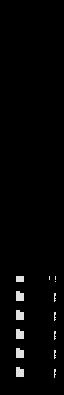

In [39]:
#Look at mask.
Image.fromarray(grey*np.uint8(mask))

In [40]:
#Make 2 new copies of the traces. 
#One is for the masked area
masked = copy.deepcopy(image_list)

#One is for the complement of the masked area
comp_masked = copy.deepcopy(image_list)

In [41]:
#Apply mask to every element
for i in range(len(masked)):
    masked[i] = masked[i] * mask

#Invert mask
mask[mask==1] = 0
mask[np.isnan(mask)] = 1
mask[mask==0] = np.nan

#Apply 
for i in range(len(comp_masked)):
    comp_masked[i] = comp_masked[i] * mask

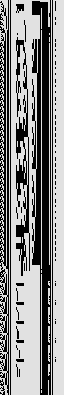

In [42]:
#Before mask.
Image.fromarray(grey*np.uint8(image_list[0]))

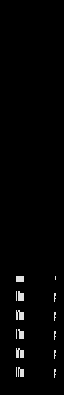

In [43]:
#After mask
Image.fromarray(grey*np.uint8(masked[0]))

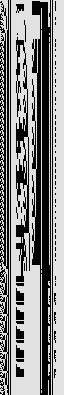

In [44]:
#Comp mask
Image.fromarray(grey*np.uint8(comp_masked[0]))

In [45]:
#Show 3 attempts at classification: baseline, with masked region, and complement of masked region.

In [46]:
#The classifier
from sklearn import svm, cross_validation
clf = svm.SVC(cache_size=7000)

In [16]:
#1
#Train baseline classifier on whole trace. >25k pix.
#Takes a few mins, should nearly perfectly separate.

#Flatten images to 1d
image_list = image_list.reshape(image_list.shape[0], -1)

#Run model
scores = cross_validation.cross_val_score(clf, image_list, labels, cv=4, n_jobs=4)
print(scores)
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.98584906  0.99292453  1.          1.        ]
Accuracy: 0.9947 (+/- 0.01)


In [17]:
#2
#Uses only the ~500 pixels that change between executions of program, way faster.
#Should have all the information as above. Should nearly perfectly separate.
num_traces = masked.shape[0]
masked = masked[~np.isnan(masked)].reshape(num_traces, -1)

scores = cross_validation.cross_val_score(clf, masked, labels, cv=4, n_jobs=8)
print(scores)
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 1.  1.  1.  1.]
Accuracy: 1.0000 (+/- 0.00)


In [49]:
#3
#Uses complement of mask. This set of pix should contain no info!
#Doing this for completeness. This is expected to fail! 
num_traces = comp_masked.shape[0]
comp_masked = comp_masked[~np.isnan(comp_masked)].reshape(num_traces, -1)
scores = cross_validation.cross_val_score(clf, comp_masked, labels, cv=4, n_jobs=8)
print(scores)
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.125  0.125  0.125  0.125]
Accuracy: 0.1250 (+/- 0.00)


In [4]:
x = range(16)
x = np.reshape(x,(4,4))

In [5]:
x

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [12]:
x[ [[1], [3]] , [1,3] ]

array([[ 5,  7],
       [13, 15]])

SyntaxError: invalid syntax (<ipython-input-8-77388587b617>, line 1)